# Plot Light curve v.10
Better to use Jupyter since I don't want to run whole code every time.

**New feature:**
* Jupyter format
* interactive plots
* Read information directly from the .lc file. (astropy package)
* (Hopefully) PSD?

<br/>

<br/>

## 1. Packages

Below is the packages and default setting to get a plot. <br/>
Of course, you can modify the fonts.

In [2]:
import numpy as np                              # basic
from scipy.optimize import curve_fit            # fit the curve
# from scipy import stats                         # linear fit
   
import matplotlib.pyplot as plt                 # plot
import matplotlib.ticker as ticker              # set ticker range
from matplotlib.patches import Rectangle        # add rectangular mark on the figure
# from matplotlib.mlab import psd

from astropy.time import Time                   # MJD <-> YMD 
from astropy.io import fits                     # I/O fits file
import astropy.units as u                       # unit info
from astropy.timeseries import aggregate_downsample     # Time bin


import sys                                      # To get bash variable in python
import os                                       # To get bash variable in python
from copy import copy, deepcopy                 # To copy the class


## To enable the interactive widgets (such as plots).
%matplotlib widget

## To print all the out put without truncating.
np.set_printoptions(threshold=sys.maxsize)

# plt.rcParams["font.family"] = "Computer Modern" # Default font for the plot
# plt.rcParams["font.weight"] = "bold"            # Default font for the plot

<br/>

## 2. Some useful function

### 1) Time conversion function

These are simple time conversion functions, useful to plot the graph in different units. <br/>
(Maybe there is made-up functions in the astropy package? Still it is not difficult at all to write my own code.)

In [3]:
# shift starting time as a MJD_START
def timeSHIFT(X) :
    Y = X - (MJD_REF - MJD_START)*86400
    return np.array(["{:.0f}".format(y) for y in Y])

# convert sec -> MJD
def timeMJD(X) :
    Y = MJD_START + X/86400
    if X[-1]-X[0] >= 864000 :       # 864000 sec = 10 days
        return np.array(["{:.0f}".format(y) for y in Y])
    else :
        return np.array(["{:.1f}".format(y) for y in Y])
    #return ["{}".format(y) for y in Y]

# set starting time as zero
def timeZERO(X):
    Y=[]
    t_start = X[0]
    for x in X :
        Y.append(x-t_start)
    Y = np.array(Y)
    return Y

# convert MJD -> year
def timeYEAR(X) :
    Y=[]
    for x in X :
        t = Time(x, format='mjd')
        t.format = 'jyear'
        Y.append(float(t.value))
    Y = np.array(Y)
    return Y

### 2) Merge fits Table
Merging light curve (fits table) sounds simple, but we need to modify the TIME column to merge two different light curves that start from 0 seconds. <br/>

https://stackoverflow.com/questions/58742707/combining-astropy-fits-files <br/>
Appending table; https://docs.astropy.org/en/stable/io/fits/usage/table.html

In [4]:
def merge_LC(output_pwd, input_pwd_1, input_pwd_2) :
    
    ## Open fits files to combine
    lc_1 = fits.open(input_pwd_1)
    lc_2 = fits.open(input_pwd_2)


    ## find which light curve was observed earlier, and save them in lc_early & lc_later
    time_start_1 = (lc_1[1].header["MJDREFF"] + lc_1[1].header["MJDREFI"]) * 86400 + lc_1[1].header["TSTART"]   # unit: seconds
    time_start_2 = (lc_1[1].header["MJDREFF"] + lc_1[1].header["MJDREFI"]) * 86400 + lc_1[1].header["TSTART"]   # unit: seconds

    if time_start_2 > time_start_1 :
        lc_early = lc_1
        lc_later = lc_2
    else :
        lc_early = lc_2
        lc_later = lc_1


    ## Convert time column to a relative time compare to the earlier observation
    lc_early[1].data['TIME'] = lc_early[1].data['TIME']
    lc_later[1].data['TIME'] = lc_later[1].data['TIME'] + lc_later[1].header['TSTART'] + abs(time_start_1 - time_start_2)


    ## Make a new fits file with merged data.
    n_rows1 = lc_early[1].data.shape[0]
    n_rows2 = lc_later[1].data.shape[0]
    n_rows = n_rows1 + n_rows2                 # add the number of the rows
    hdu = fits.BinTableHDU.from_columns(columns=lc_early[1].columns, nrows=n_rows, header=lc_early[1].header)    # New fits file
    for column_name in lc_1[1].columns.names :
        hdu.data[column_name][n_rows1:] = lc_later[1].data[column_name]      # Add lc_later


    hdu.writeto(output_pwd, overwrite=True) 


In [5]:
# TEST

# output_pwd = "/Users/jungeun/Desktop/R/NGC4151/merged.lc"
# input_pwd_1 = "/Users/jungeun/Desktop/R/NGC4151/after20230522/NGC4151_cl_merged_NIGHT_after_2.lc"
# input_pwd_2 = "/Users/jungeun/Desktop/R/NGC4151/before20230522/NGC4151_cl_merged_ALL.lc"

# merge_LC(output_pwd, input_pwd_1, input_pwd_2) 

<br/>

## 3. Attributes for light curve & PSD data

We will going to define a class attribute for Lightcurve & PSD. <br/>
Class is an object that provides data(attributes) and functions. If you are new to Class type, refer below:
* Official python documents https://docs.python.org/3/tutorial/classes.html
* Simple examples with results https://www.w3schools.com/python/python_classes.asp

Also, it is convenient to use `.fits`(=`.lc`) file. About the fits file handling in `astropy`, refer below:
* `astropy` fits file handling; https://docs.astropy.org/en/latest/io/fits/index.html
* `astropy` fits header; https://docs.astropy.org/en/latest/io/fits/usage/headers.html
* `astropy` table data; https://docs.astropy.org/en/latest/io/fits/usage/table.html

<br/>

### 1) Define `LCdata` class attribute

In [6]:
class LCdata :
    def __init__(self, input_pwd, bkg) :
        lc = fits.open(input_pwd)
        self.input_pwd = input_pwd
        self.bkg = bkg


        self.telescope = lc[1].header["TELESCOP"]   # telescope name
        self.object = lc[1].header["OBJECT"]        # object name
        self.obs_id = lc[1].header["OBS_ID"]        # observation id
        

        if self.telescope == "NICER" :
            ## Observation information
            self.binsize = lc[1].header["TIMEDEL"]              # binsize
            self.E_start = lc[1].header["PHALCUT"] * 0.01       # energy cut in keV (low)
            self.E_end = lc[1].header["PHAHCUT"] * 0.01         # energy cut in keV (high)
            
            # Date information
            self.MJD_REF = lc[1].header["MJDREFF"] + lc[1].header["MJDREFI"]    # reference date in MJD
            self.MJD_OBS = self.MJD_REF + (lc[1].header["TSTART"]/86400)        # observation date in MJD

        elif self.telescope == "XMM" :
            ## Observation information
            self.binsize = lc[1].header["TIMEDEL"]              #binsize
            self.E_start = lc[1].header["CHANMIN"] * 0.001      # energy cut in keV (low)
            self.E_end = lc[1].header["CHANMAX"] * 0.001        # energy cut in keV (high)

            ## Date information
            self.MJD_REF = lc[1].header["MJDREF"]                               # reference date in MJD 
            try : 
                self.MJD_OBS = lc[1].header["MJD-OBS"]                          # observation date in MJD                       
            except : 
                self.MJD_OBS = self.MJD_REF + (lc[1].header["TSTART"]/86400)    # observation date in MJD


        # Remove NaN, zero or negative values for the count rate.
        if bkg != True :
            bad = np.logical_or(np.isnan(lc[1].data.field(1)), lc[1].data.field(1) < 0)
            # check the time that has bad value.
                # t = Time(np.divide(timeZERO(lc[1].data.field(0)), 86400)[bad] + self.MJD_OBS, format='mjd')
                # t.format = 'isot'
                # t = t.utc
                # print(t)
            lc[1].data = lc[1].data[~bad]
            # self.bad = bad


        # Remove data has non-zero FRACEXP
        if self.telescope == "NICER" :
            bad = np.logical_or(lc[1].data.field(3) < 1, False)
            # print(lc[1].data.field(3)[bad])
            lc[1].data = lc[1].data[~bad]


        # Remove the data points that has high error 
        bad = np.logical_or(lc[1].data.field(2) > 10, False)
        lc[1].data = lc[1].data[~bad]


        # Light curve information
        # NICER : lc[1].data has 'TIME', 'RATE', 'ERROR', 'FRACEXP', 'NUM_FPM_SEL', 'BACKV', 'BACKE'.
        # XMM   : lc[1].data has 'TIME', 'RATE', 'ERROR', 'NUM_FPM_SEL', 'BACKV', 'BACKE'.
        self.time_sec_start = lc[1].data.field(0)[0]
        self.time_sec = lc[1].data.field(0)
        if bkg == True :
            try :
                if self.telescope == "NICER" :
                    self.count_rate = lc[1].data.field(5)
                    self.error = lc[1].data.field(6)
                elif self.telescope == "XMM" :
                    self.count_rate = lc[1].data.field(4)
                    self.error = lc[1].data.field(5)
            except :
                self.count_rate = lc[1].data.field(1)
                self.error = lc[1].data.field(2)
        else :
            self.count_rate = lc[1].data.field(1)
            self.error = lc[1].data.field(2)
        self.time_MJD = np.divide(self.time_sec, 86400) + self.MJD_OBS


        # Keep the .fits file
        self.fits = lc


    # Class attribute cannot be copied without corrupting the original data. We need a function for it.
    def __copy__(self) :
        # return LCdata(self.input_pwd)
        new_LCdata = type(self).__new__(self.__class__)
        new_LCdata.__dict__.update(self.__dict__)
        return new_LCdata


    # To cut a data and make a LCchunk data.
    def cut_fits(self, i, j) :
        self.time_sec = self.time_sec[i:j]
        self.count_rate = self.count_rate[i:j]
        self.error = self.error[i:j]
        self.time_MJD = self.time_MJD[i:j]
        
        self.fits[1].data = self.fits[1].data[i:j]

        return self


    # To check Check KP value.
    # This mostly work for the NICER data. We need `.mkf` file to check KP value. KP value should not be larger than 4.
    def check_KP(self, input_kp_pwd) :
        kpfile = fits.open(input_kp_pwd)
        kp_time= timeZERO(kpfile[1].data.field(0))
        kp = kpfile[1].data.field(1)

        bad_kp = np.zeros(len(self.time_sec), dtype='bool')
        kp_threshold = 4

        for j in range(len(bad_kp)) :
            kp_time_index = min(range(len(kp_time)), key=lambda i: abs(kp_time[i]-self.time_sec[j]))
            if kp_time_index < len(kp_time)-1 and (kp[kp_time_index] >=4 or kp[kp_time_index+1] >= 4) :
                print(kp[kp_time_index], kp[kp_time_index+1])
                bad_kp[j] = True
            else :
                bad_kp[j] = False

        
        self.fits[1].data = self.fits[1].data[~bad_kp]


        self.time_sec = timeZERO(self.fits[1].data.field(0))
        if self.telescope == "XMM" and self.bkg == True :
            self.count_rate = self.fits[1].data.field(4)
            self.error = self.fits[1].data.field(5)
        else :
            self.count_rate = self.fits[1].data.field(1)
            self.error = self.fits[1].data.field(2)
        self.time_MJD = np.divide(self.time_sec, 86400) + self.MJD_OBS

        return self


    # Save a fits file as another .fits file.
    def save_fits(self, output_pwd) :
        self.fits.writeto(output_pwd, overwrite=True)
    

    # Save a fits file as a .txt file.
    def save_txt(self, output_pwd) :
        with open(output_pwd, 'w') as file :
            file.seek(0)   # overwrite
            file.write(', '.join(self.fits[1].data.names))
            file.write('\n')
            file.write(', '.join([str(self.fits[1].columns[i].unit) for i in range(len(self.fits[1].columns))]))
            file.write('\n')
            for i in range(len(self.fits[1].data.field(0))) :
                file.write(', '.join([str(self.fits[1].data.field(j)[i]) for j in range(len(self.fits[1].columns))]))
                file.write('\n')

In [7]:
    # # Remove NaN, zero or negative values for the count rate.
    # def cut_bads(self) :
    #     lc = self.fits
    #     bad = np.logical_or(np.isnan(lc[1].data.field(1)), lc[1].data.field(1) < 0)
    #     print(np.sum(bad))
    #     lc[1].data = lc[1].data[~bad]
    #     self.bad = bad

    #     # lc[1].data.field(0) = timeZERO(lc[1].data.field(0))
    #     self.time_sec = lc[1].data.field(0)
    #     self.count_rate = lc[1].data.field(1)
    #     self.error = lc[1].data.field(2)
    #     self.time_MJD = np.divide(self.time_sec, 86400) + self.MJD_OBS

    #     # Keep the .fits file
    #     self.fits = lc

    #     return self

In [8]:
# TEST (read_LC function)

# class LCdata :
#     def __init__(self, input_pwd, bkg) :
#         lc = fits.open(input_pwd)
#         self.input_pwd = input_pwd
#         self.bkg = bkg

#         # Remove NaN, zero or negative values for the count rate.
#         if bkg != True :
#             bad = np.logical_or(np.isnan(lc[1].data.field(1)), lc[1].data.field(1) < 0)
#             lc[1].data = lc[1].data[~bad]
#             self.bad = bad


#         self.telescope = lc[1].header["TELESCOP"]   # telescope name
#         self.object = lc[1].header["OBJECT"]        # object name
#         self.obs_id = lc[1].header["OBS_ID"]        # observation id
        

#         if self.telescope == "NICER" :
#             ## Observation information
#             self.binsize = lc[1].header["TIMEDEL"]              # binsize
#             self.E_start = lc[1].header["PHALCUT"] * 0.01       # energy cut in keV (low)
#             self.E_end = lc[1].header["PHAHCUT"] * 0.01         # energy cut in keV (high)
            
#             # Date information
#             self.MJD_REF = lc[1].header["MJDREFF"] + lc[1].header["MJDREFI"]    # reference date in MJD
#             self.MJD_OBS = self.MJD_REF + (lc[1].header["TSTART"]/86400)        # observation date in MJD

#         elif self.telescope == "XMM" :
#             ## Observation information
#             self.binsize = lc[1].header["TIMEDEL"]              #binsize
#             self.E_start = lc[1].header["CHANMIN"] * 0.001      # energy cut in keV (low)
#             self.E_end = lc[1].header["CHANMAX"] * 0.001        # energy cut in keV (high)

#             ## Date information
#             self.MJD_REF = lc[1].header["MJDREF"]                               # reference date in MJD    
#             self.MJD_OBS = self.MJD_REF + (lc[1].header["TSTART"]/86400)        # observation date in MJD

#         # Light curve information
#         # NICER : lc[1].data has 'TIME', 'RATE', 'ERROR', 'FRACEXP', 'NUM_FPM_SEL', 'BACKV', 'BACKE'.
#         # XMM   : lc[1].data has 'TIME', 'RATE', 'ERROR', 'NUM_FPM_SEL', 'BACKV', 'BACKE'.
#         # self.time_sec = timeZERO(lc[1].data.field(0))
#         # if self.telescope == "XMM" and self.bkg == True :
#         #     self.count_rate = lc[1].data.field(4)
#         #     self.error = lc[1].data.field(5)
#         # else :
#         #     self.count_rate = lc[1].data.field(1)
#         #     self.error = lc[1].data.field(2)
#         # self.time_MJD = np.divide(self.time_sec, 86400) + self.MJD_OBS

#         self.time_sec = None
#         self.count_rate = None
#         self.error = None 
#         self.time_MJD = None 

#         # Keep the .fits file
#         self.fits = lc
#         self = self.read_LC()

    
#     # Read light curve value from fits 
#     def read_LC(self) :
#         copy_self = copy(self)
#         lc = copy_self.fits

#         copy_self.time_sec = timeZERO(lc[1].data.field(0))
#         if copy_self.telescope == "XMM" and copy_self.bkg == True :
#             copy_self.count_rate = lc[1].data.field(4)
#             copy_self.error = lc[1].data.field(5)
#         else :
#             copy_self.count_rate = lc[1].data.field(1)
#             copy_self.error = lc[1].data.field(2)
#         copy_self.time_MJD = np.divide(copy_self.time_sec, 86400) + copy_self.MJD_OBS

#         return copy_self





#     # Class attribute cannot be copied without corrupting the original data. We need a function for it.
#     def __copy__(self) :
#         # return LCdata(self.input_pwd)
#         new_LCdata = type(self).__new__(self.__class__)
#         new_LCdata.__dict__.update(self.__dict__)
#         return new_LCdata


#     # To cut a data and make a LCchunk data.
#     def cut_fits(self, i, j) :
#         # self.time_sec = self.time_sec[i:j]
#         # self.count_rate = self.count_rate[i:j]
#         # self.error = self.error[i:j]
#         # self.time_MJD = self.time_MJD[i:j

#         self.fits[1].data = self.fits[1].data[i:j]
#         self = self.read_LC()

#         return self



#     def check_KP(self, input_kp_pwd) :
#         kpfile = fits.open(input_mkf_pwd)
#         kp_time = timeZERO(kpfile[1].data.field(0))
#         kp = kpfile[1].data.field(1)
        
#         bad_KP = []
#         for i in range(len(kp)) :
#             if kp[i] >= 4 :
#                 print(kp[i])
#                 bad_KP.append(True)
#             else :
#                 bad_KP.append(False)
#         self.fits[1].data = self.fits[1].data[~bad_KP]
#         self = self.read_LC()

#         # self.time_sec = timeZERO(lc[1].data.field(0))
#         # if self.telescope == "XMM" and bkg == True :
#         #     self.count_rate = lc[1].data.field(4)
#         #     self.error = lc[1].data.field(5)
#         # else :
#         #     self.count_rate = lc[1].data.field(1)
#         #     self.error = lc[1].data.field(2)
#         # self.time_MJD = np.divide(self.time_sec, 86400) + self.MJD_OBS

#         return self


#     # Save a fits file as another .fits file.
#     def save_fits(self, output_pwd) :
#         self.fits.writeto(output_pwd, overwrite=True)
    

#     # Save a fits file as a .txt file.
#     def save_txt(self, output_pwd) :
#         with open(output_pwd, 'w') as file :
#             file.seek(0)   # overwrite
#             file.write(', '.join(self.fits[1].data.names))
#             file.write('\n')
#             file.write(', '.join([str(self.fits[1].columns[i].unit) for i in range(len(self.fits[1].columns))]))
#             file.write('\n')
#             for i in range(len(self.fits[1].data.field(0))) :
#                 file.write(', '.join([str(self.fits[1].data.field(j)[i]) for j in range(len(self.fits[1].columns))]))
#                 file.write('\n')

<br/><br/>

### 2) Define `PSDdata` class attribute

#### 2.1) | Discrete Fourier Transform |<sup>2</sup>
The absolute value of discrete Fourier transform function is:
$$ |DFT(f_j)|^2 = \bigg|\sum_{i=0}^{N-1} x_i e^{-2\pi i f_j t_i} \bigg|^2 = \left[ \sum_{i=0}^{N-1} x_i \cos(2\pi f_j t_i)  \right]^2 + \left[ \sum_{i=0}^{N-1} x_i \sin(2\pi f_j t_i)  \right]^2 \tag{\small eq. 1 in Vaughan 2003} $$ 
$$ t_i = n \Delta t \quad\quad f_j = \frac{k}{N \Delta t},  \quad\quad  (n = 0, 1, 2, \cdots, N-1, k = 0, 1, 2, \cdots, \frac{N-1}{2})$$
where $\Delta t$ is a time binning.
<!-- Thus,  -->
<!-- $$ |DFT(f)|^2 = \left[ \sum_{k=0}^{N-1}\sum_{n=0}^{N-1} x_i \cos \left( 2\pi \frac{k}{N}n \right)  \right]^2 + \left[ \sum_{k=0}^{N-1}\sum_{n=0}^{N-1} x_i \sin \left( 2\pi \frac{k}{N}n \right)  \right]^2  $$  -->

$$ A_{\mathrm{rms}^2} = 2 \frac{\Delta T_{\mathrm{samp}}}{N \bar{x}^2} $$
**More information** <br/>
* About the last equation: https://en.wikipedia.org/wiki/Discrete_Fourier_transform
* Some practice of DFT: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html 

<br/>

In [9]:
class PSDdata :
    def __init__(self, LCchunk) :
        # Basic information
        self.lc_fits = LCchunk.fits
        self.telescope = LCchunk.telescope      # telescope name
        self.object = LCchunk.object            # object name
        self.obs_id = LCchunk.obs_id            # observation id
        self.binsize = LCchunk.binsize          # binsize
        self.E_start = LCchunk.E_start          # energy cut in keV (low)
        self.E_end = LCchunk.E_end              # energy cut in keV (high)

        self.N = len(LCchunk.time_sec)
        self.freq = np.arange(1, self.N//2) / (self.N * self.binsize)
        self.norm = 2 * self.binsize / (len(LCchunk.count_rate) * (np.average(LCchunk.count_rate)**2))
        self.norm_err = None

        # Calculate PSD
        dt = self.binsize * np.arange(self.N)                 # array of integers; n = 0, 1, ..., N-1
        f = self.freq.reshape((len(self.freq), 1))          # Transpose of n = 0, 1, ..., N-1
        exp = np.exp(- 2j * np.pi * f * dt)                 # 2D array (k * n)
        X_exp = np.dot(exp, LCchunk.count_rate)             # dot product between 2D array (sin) and 1D array (x)
        self.PSD = self.norm * np.square(np.abs(X_exp))
        self.PSD_error = None


    # Bin the PSD for certain number of points (Due to lack of chunks, mostly num=2)
    def bin_PSDavg(self, num) :
        freq = []
        PSD = []
        PSD_error = []
        for i in range(0, len(self.PSD), num) :
            freq.append(np.mean(self.freq[i:i+num]))
            PSD.append(np.mean(self.PSD[i:i+num]))
            PSD_error.append(np.sqrt( np.sum(self.PSD_error[i:i+num]**2) ) / num)
        self.freq = np.array(freq)
        self.PSD = np.array(PSD)
        self.PSD_error = np.array(PSD_error)


    # Class attribute cannot be copied without corrupting the original data. We need a function for it.
    def __copy__(self) :
        # return LCdata(self.input_pwd)
        obj = type(self).__new__(self.__class__)
        obj.__dict__.update(self.__dict__)
        return obj


    # Save a fits file as a .txt file.
    def save_txt(self, output_pwd) :
        with open(output_pwd, 'w') as file :
            file.seek(0)   # overwrite

            try : 
                if self.PSD_error == None :                     # If the PSDdata is not an averaged PSD
                    file.write("Frequency, PSD")
                    file.write('\n')
                    file.write("Hz, (rms/mean)^2 Hz^-1")
                    file.write('\n')
                    for i in range(len(self.freq)) :
                        file.write("{}, {}".format(self.freq[i], self.PSD[i]))
                        file.write('\n')
                    
            except :                                            # If the PSDdata is an averaged PSD
                file.write("Frequency, PSD, error")
                file.write('\n')
                file.write("Hz, (rms/mean)^2 Hz^-1, (rms/mean)^2 Hz^-1")
                file.write('\n')
                for i in range(len(self.freq)) :
                    file.write("{}, {}, {}".format(self.freq[i], self.PSD[i], self.PSD_error[i]))
                    file.write('\n')

    
    # Save fits file for xspec.
    def save_pha(self, output_pwd) :
        freq_bin = self.freq[1]-self.freq[0]

        try : 
            if self.PSD_error == None :                     # If the PSDdata is not an averaged PSD, bail out.
                print("Wrong input; Not an averaged PSD.")
                return

        except :
            with open(output_pwd, 'w') as file :
                file.seek(0)   # overwrite
                file.write("Freq_min, Freq_max, PSD*bin, PSD_error*bin")
                file.write('\n')
                file.write("Hz, Hz, (rms/mean)^2, (rms/mean)^2")
                file.write('\n')
                for i in range(len(self.freq)) :
                    file.write("{}, {}, {}, {}".format(self.freq[i] - (freq_bin/2), self.freq[i] + (freq_bin/2), self.PSD[i]*freq_bin, self.PSD_error[i]*freq_bin))
                    file.write('\n')
        

        
    def make_pha(self, output_pwd) :
        freq_bin = self.freq[1]-self.freq[0]

        # Make a empty fits file
        # hdu = fits.BinTableHDU.from_columns(columns=["Freq_min", "Freq_max", "PSD*bin", "PSD_error*bin"], nrows=len(self.freq), header=self.lc_fits[1].header)
        
        # Now add each column for .pha file
        c1 = fits.Column(name="Freq_min", array=self.freq - (freq_bin/2), format='D')
        c2 = fits.Column(name="Freq_max", array=self.freq + (freq_bin/2), format='D')
        c3 = fits.Column(name="PSD*bin", array=self.PSD*freq_bin, format='D')
        c4 = fits.Column(name="PSD_error*bin", array=self.PSD_error*freq_bin, format='D')
        hdu = fits.BinTableHDU.from_columns(columns=[c1, c2, c3, c4], header=self.lc_fits[1].header)

        # Save fits file       
        hdu.writeto(output_pwd, overwrite=True) 

        return hdu

<br/><br/>

## 4. Plot light curve

Now let's plot the actual light curve. There are several cases what we want to plot.

### 1) Plot light curve with background

Most typical light curve is to plot it with its background light curve.<br/>
**Make sure you specified the background light curve directory path, and loaded them.**

Below is a plot function:

In [106]:
def plot_lightcurve_n_bkg(src_lc, bkg_lc, save_txt, save_fig, show) : 

    fig = plt.figure(figsize=(12, 5))

    # Add two different axis (to plot sec & MJD at the same time)
    ax1 = fig.add_subplot(111)
    # axis thickness
    for axis in ['top', 'bottom', 'left', 'right']:
        ax1.spines[axis].set_linewidth(3)  # change width


    if int(src_lc.time_MJD[-1]) - int(src_lc.time_MJD[0]) > 1 :
        second_xaxis = True
        ax2 = ax1.twiny()
    else :
        second_xaxis = False
        
    
    ax1.errorbar(timeZERO(src_lc.time_sec), src_lc.count_rate, src_lc.error, ls='none', elinewidth=1, color='#0034ca', marker='o', markersize=8, alpha = 0.7,
                    label="Source", zorder=10) #1d50e2
    
    if bkg_lc != None and second_xaxis == True :
        ax2.errorbar(bkg_lc.time_MJD, bkg_lc.count_rate, bkg_lc.error, ls='none', elinewidth=1, ecolor='black', marker='o', markersize=8, alpha = 0.7,
                        label="Background", color='#FE7171', zorder=1)
    elif second_xaxis == True  :
        ax2.errorbar(timeYEAR(src_lc.time_MJD), src_lc.count_rate, src_lc.error, ls='none', elinewidth=1, ecolor='black', marker='o', markersize=8, 
                        alpha = 0.7, label="Background", color='#FE7171', zorder=1)

    # --- ax1 ; Fixed  ---
    ax1.set_ylabel('Count rate (count $\mathregular{s^{-1}}$)', size=25, labelpad=7.5)
    ax1.set_xlabel(r'Time (sec)', size=22, labelpad=7.5)
    # ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.tick_params(axis='both', labelsize=20, width=1.2, length=20, which='major', direction='in')
    ax1.tick_params(axis='both', labelsize=20, width=1.2, length=10, which='minor', direction='in')
    # ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%2f'))
    # ax1.set_xticklabels(ax1.get_xticks(), weight='bold')
    # ax1.set_yticklabels(ax1.get_yticks(), weight='bold')
    # ax1.xaxis.set_ticks_position('both')
    ax1.yaxis.set_ticks_position('both')
    #ax1.grid(axis='x', color='#909090', linestyle=':', linewidth=5)
    #ax1.legend(prop={'size': 20})

    # --- ax2 ; can be MJD, can be started from zero ---
    if second_xaxis == True :
        ax2.set_xlabel('Time (MJD)', size=22, labelpad=15)
        # ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.tick_params(axis="x", labelsize=20, width=1.2, length=20, which='major', direction='in')
        ax2.tick_params(axis="x", labelsize=20, width=1.2, length=10, which='minor', direction='in')
        ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
        # ax2.set_xticks(np.arange(2018, 2023, 1))
        ax2.xaxis.offsetText.set_fontsize(20)
        # ax2.set_xticklabels(ax2.get_xticks(), weight='bold')
        # ax2.set_yticklabels(ax2.get_yticks(), weight='bold')
        #ax2.grid(axis='x', color='grey', linestyle=':', linewidth=1)

        # Title and legend
        plot1, label1 = ax1.get_legend_handles_labels()
        plot2, label2 = ax2.get_legend_handles_labels()
        ax2.legend(plot1 + plot2, label1 + label2, loc=9, prop={'size': 20}, frameon=False, markerscale=1, handletextpad=0.1) # loc=9


    
    if save_txt == True :
        src_lc.save_txt(output_pwd + "{}_{}_src_lc_bin{:.9g}_{}-{}keV.txt".format(src_lc.telescope, src_lc.object, float(src_lc.binsize), src_lc.E_start, src_lc.E_end))
        bkg_lc.save_txt(output_pwd + "{}_{}_bkg_lc_bin{:.9g}_{}-{}keV.txt".format(bkg_lc.telescope, bkg_lc.object, float(bkg_lc.binsize), bkg_lc.E_start, bkg_lc.E_end))

    if save_fig == True :
        plt.savefig(output_pwd + "{}_{}_lc_bin{:.9g}_{}-{}keV_flare5.png".format(src_lc.telescope, src_lc.object, float(src_lc.binsize), src_lc.E_start, src_lc.E_end), bbox_inches = "tight", dpi=600, transparent=False)   #, format='eps'
        print("< Figure saved >") 

    if show == True :
        plt.tight_layout()
        plt.show()

### 2) Maybe NICER & XMM

Needs to add

<br/><br/>

## 5. Plot PSD

**Main Reference**
* Vaughan, 2003, [*On characterizing the variability properties of X-ray light curves from active galaxies*](https://doi.org/10.1046/j.1365-2966.2003.07042.x)

$$ P(f_j) = A |DFT(f_j)|^2 \tag{\small eq. 2 in Vaughan 2003} $$ 
$$ A_{\mathrm{rms}^2} = \frac{2 \Delta T_{\mathrm{samp}}}{ N\bar{x}^2 } \tag{\small Appendix A. in Vaughan 2003} $$
$$ P_{\mathrm{noise}} = \frac{2 (\bar{x} + \bar{x}_b)}{\bar{x}^2} \frac{\Delta T_{\mathrm{samp}}}{\Delta T_{\mathrm{bin}}} \tag{\small eq. A2 in Vaughan 2003} $$
where
* $N$: sample number
* $P(f_j)$: Periodogram at frequency $f_j$ ($j = 0, 1, 2, \cdots N-1$)
* $A_{\mathrm{rms}^2}$: normalization factor
* $P_{\mathrm{noise}}$: Poisson noise
* $\bar{x}$: an average value for the source light curve
* $\bar{x}_b$: an average value for the background light curve
* $\Delta T_{\mathrm{samp}}$: sampling rate
* $\Delta T_{\mathrm{bin}}$: time binning

<br/>

**More reference**

* Fast Fourier Transform, wiki; (https://en.wikipedia.org/wiki/Fast_Fourier_transform#:~:text=A%20Fast%20Fourier%20Transform%20)
* `numpy`, Discrete Fourier Transform; (https://numpy.org/doc/stable/reference/routines.fft.html)
* `matplotlib`, Power spectral density (PSD); (https://matplotlib.org/stable/gallery/lines_bars_and_markers/psd_demo.html)

<br/>

### 1) Split Light curve to evenly sampled chunks

In [11]:
def get_list_LC(src_lc, plot, save) :
    # Parameters that required
    if src_lc.telescope == "NICER" :
        PSD_duration = 1000                     # unit: second
    elif src_lc.telescope == "XMM" :
        PSD_duration = 20000                     # unit: second
    print("PSD duration:", PSD_duration, "sec")

    binsize = src_lc.binsize
    print("binsize:", binsize)

    sample_interval = binsize
    sample_rate = 1.0/sample_interval


    # Define empty list for chunks. This is (2, number of chunks) dimension np.array. 2 refers to source & background light curve
    list_LCchunks = []

    # i: starting index of the LCchunk / j: ending index of the LCchunk
    i = 0
    for j in range(len(src_lc.time_sec)) :
        if j != 0 and src_lc.time_sec[j]-src_lc.time_sec[j-1] > binsize :        # if the time gap between two data point is larger than binsize
            # reset for the next LCchunk
            # if j-i == 1 :
            #     print(src_lc.time_sec[j]-src_lc.time_sec[i])
            i = j
            
        if src_lc.time_sec[j]-src_lc.time_sec[i] >= PSD_duration :
            # copy the whole file to keep the header
            temp_LCchunk = copy(src_lc)
            temp_LCchunk_bkg = copy(bkg_lc)
            
            # # copy the LCchunk data within [i:j]
            temp_LCchunk.cut_fits(i, j)
            temp_LCchunk_bkg.cut_fits(i, j)
            
            # add this LCchunk to the list_LCchunks
            list_LCchunks.append([temp_LCchunk, temp_LCchunk_bkg])

            # Plot the chunk light curves.
            if plot == True :
                plot_lightcurve_n_bkg(temp_LCchunk, temp_LCchunk_bkg, False)

            # Save chunk files
            if save == True :
                temp_LCchunk[0].save_fits(output_pwd + "chunk{}_lc.fits".format(i))
                temp_LCchunk[0].save_txt(output_pwd + "chunk{}_lc.txt".format(i))
    
            # reset for the next LCchunk
            i = j


    list_LCchunks = np.array(list_LCchunks)
    print("Number of chunks:", len(list_LCchunks))

    return list_LCchunks

In [12]:
# TEST

# # Set time to start from zero
# list_LCchunks[2][0].time_sec = timeZERO(list_LCchunks[2][0].time_sec)
# list_LCchunks[2][1].time_sec = timeZERO(list_LCchunks[2][1].time_sec)

# # Plot ans save
# plot_lightcurve_n_bkg(list_LCchunks[2][0], list_LCchunks[2][1], False)
# # list_LCchunks[23][0].save_fits("/Users/jungeun/Desktop/R/NGC4395/LCchunk23.lc")
# # list_LCchunks[23][1].save_fits("/Users/jungeun/Desktop/R/NGC4395/LCchunk23_bkg.lc")

~~Best chunk: 6100180108 (23rd chunk)~~ &rarr; **likely the light leakage**

<br/><br/>

### 2) Linear fit of PSD slope
When we plot the PSD in log-log scale, the plot tends to be linear. To fit a linear curve within the log-log scale, we will follow below 3 steps:
1. Take a log function to the both x & y data. (log 10)
2. Perform the linear fit to the log(x) & log(y). &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; ($\log_{10}(y) = A \log_{10}(x) + B$)
3. Reverse to a normal scale by taking exponential(10). &emsp;&emsp; ($y = 10^{B} x^{A}$)


Technical references:
* `scipy.optimize.curve_fit`; [scipy.org](https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.optimize.curve_fit.html)

Practical references:
* How to apply linear fit;  [stackoverflow](https://stackoverflow.com/questions/22240280/least-squares-fit-to-a-straight-line-python-code)
* What are the `popt` & `pcov`;  [stackoverflow](https://stackoverflow.com/questions/51059863/why-pcov-in-optimize-curve-fit-is-a-two-by-two-matrix-and-which-value-correspond)

<br/>

In [13]:
# linear fit function
def linear_curve(x, A, B):
    return A*x + B

# inverse log function
def exp10_curve(x, A, B):
    return (10**B) * (x**A)

In [14]:
def plot_linear_fit(PSDdata, show, return_fit, **kwargs) :
    # kwargs = {'color': (*, *, *), 'exclude': integer}

    # Exclude Poisson noise part for the PSD
    if PSDdata.telescope == "NICER" and ('exclude' not in kwargs or kwargs['exclude'] == None) :
        exclude = int(-0.9 * len(PSDdata.freq))       # NICER 
    elif PSDdata.telescope == "XMM" and ('exclude' not in kwargs or kwargs['exclude'] == None) :
        exclude = int(-0.96 * len(PSDdata.freq))      # XMM
    elif 'exclude' in kwargs :
        exclude = kwargs['exclude']

    # Set default color as 'blue' if there was no specified color input.
    if 'color' not in kwargs or kwargs['color'] == None :
        color = 'black'
    else :
        color = kwargs['color']



    # 1. Take a log function to the both x & y data.
    x = np.log10(PSDdata.freq)                                      # [1:] => To avoid infinite value since time_sec starts from 0, log10(0) = inf.
    y = np.log10(PSDdata.PSD)                                       # To have a same size with x

    # 2. Perform the linear fit to the log(x) & log(y).
    popt, pcov = curve_fit(linear_curve, x[:exclude], y[:exclude])    # [:-200] => exclude flattened data points in the PSD (Poisson noise)
    
    slope, intercept = popt
    slope_std_err = pcov[0][0]

    # 3. Reverse to a normal scale by taking exponential(10). 
    line = exp10_curve(PSDdata.freq[:exclude], slope, intercept)



    # Plot the linear fit
    plt.plot(PSDdata.freq[:len(line)], line, linestyle="-", c=color, linewidth=2, alpha=1.0, label='Slope={:.4f}$\pm${:.2f}'.format(slope, slope_std_err))
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    if show == True :
        plt.show()

    if return_fit == True :
        return line, slope, slope_std_err

In [15]:
def plot_PSD(PSDdata, show, newfig, **kwargs) :

    if newfig != False :
        plt.figure(figsize = (7, 5))

    if PSDdata.telescope == "NICER" and ('color' not in kwargs or kwargs['color'] == None) :
        color = (0, 0.5, 0)
    elif PSDdata.telescope == "XMM" and ('color' not in kwargs or kwargs['color'] == None) :
        color = (1, 0, 0) 
    else :
        color = kwargs['color']
    
    try :
        if PSDdata.PSD_error == None :
            plt.plot(PSDdata.freq, PSDdata.PSD, c=color, alpha=0.5, label="{} PSD".format(PSDdata.telescope))
    except :
            plt.errorbar(PSDdata.freq, PSDdata.PSD, PSDdata.PSD_error, ls='none', elinewidth=1, marker='o', c=color, alpha=0.5, label="{} PSD".format(PSDdata.telescope))
    
    plt.xlabel(r'Freq ($\mathrm{Hz}$)')
    plt.ylabel(r'PSD ($(\mathrm{rms}/\mathrm{mean})^{2} \mathrm{Hz}^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')

    plt.legend()
    plt.tight_layout()
    if show == True :
        plt.show()

In [16]:
# TEST

# # Bindu_f = np.array([0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02,0.021,0.022,0.023,0.024,0.025,0.026,0.027,0.028,0.029,0.03,0.031,0.032,0.033,0.034,0.035,0.036,0.037,0.038,0.039,0.04,0.041,0.042,0.043,0.044,0.045,0.046,0.047,0.048,0.049])
# # Bindu_PSD = np.array([962.6584,252.0669,69.36622,14.94784,2.024861,0.04786291,0.1135953,0.07012564,0.02896564,0.1239724,0.1115335,0.1946351,0.209289,0.4824484,0.3230747,0.2495915,0.4390818,0.3603992,0.5120036,0.2069954,0.2992283,0.3297498,0.1563204,0.3102064,0.1606037,0.282561,0.2285759,0.4896971,0.4522646,0.06929566,0.02175305,0.2755165,0.3383866,0.1040609,0.004894947,0.08263216,0.05950953,0.230742,0.3268168,0.3502154,0.2917411,0.03867257,0.03836795,0.03484441,0.2437705,0.1784519,0.249541,0.06536901,0.01418113])

# LCchunk, LCchunk_bkg = list_LCchunks[23]
# PSDchunk = PSDdata(LCchunk)
# plot_PSD(PSDchunk, show=False, newfig=True)

# # plt.plot(Bindu_f, Bindu_PSD, label="Bindu", c='r', linestyle="--", alpha=0.7)

# plt.legend()
# plt.show()

# # power, psd_frequencies = psd(LCchunk.count_rate, NFFT=175, Fs=1./sample_interval)
# # plt.plot(psd_frequencies, power, label='built-in module')

<br/>

### 3) Average out the PSD from different chunks

Make a list of PSD chunks.

In [17]:
def get_list_PSD(list_LCchunks, plot, save) :
    list_PSDchunks = []
    # plt.figure(figsize = (8, 6))

    i=0
    NaN_norm = []
    for j in range(len(list_LCchunks)):
        
        # Get individual LCchunk data
        PSDchunk = PSDdata(list_LCchunks[j][0])

        # If the norm of the PSD is nan, we exclude them. (In this case, nan is due to extremely low count rate, which cause infinity as a norm.)
        if np.isnan(PSDchunk.norm) :
            print(i, "(Norm is NaN)")
            NaN_norm.append(i)
        else :
            # print(i)
            list_PSDchunks.append(PSDchunk)

        ## Plot the multiple PSD from each chunks.
        if plot == True :
            plot_PSD(PSDchunk, show=True, newfig=True)

        ## Save each chunks
        if save == True :
            PSDchunk.save_txt(output_pwd + "chunk{}_PSD.txt".format(i))
        
        i+=1

    if plot == True :
        plt.xscale('log')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

    list_PSDchunks = np.array(list_PSDchunks)
    print("Number of NaN:", len(NaN_norm))
    print("Total available chunks:", len(list_PSDchunks))

    return list_PSDchunks

<br/>
Then take an average.

In [18]:
def average_PSD(list_PSDchunks, save) :
    # Since list_PSDchunks is a list of PSDdata attribute, we will collect the PSD data only.
    # Also we will calculate average norm value.
    list_only_PSD = []
    norm_avg = []

    for PSDchunk in list_PSDchunks :
        list_only_PSD.append(PSDchunk.PSD)
        norm_avg.append(PSDchunk.norm)
    list_only_PSD = np.array(list_only_PSD)
    norm_avg, norm_error = np.mean(np.array(norm_avg)), np.std(np.array(norm_avg))/np.sqrt(len(norm_avg))
    
    # Below -- (number of chunks, number of frequency domain - 1); Reason for -1 is to exclude zero frequency which is not reliable. 
    print(list_only_PSD.shape, "   -> (number of chunks, number of frequency domain - 1)")

    # Take an average by column.
    PSD_avg = np.array([np.mean(list_only_PSD, axis=0), np.std(list_only_PSD, axis=0)/np.sqrt(len(list_only_PSD))])
    # Reshape them back (PSD by chunk * each freq -> PSD by freq * each chunk)
    # PSD_avg = np.reshape(PSD_avg, (len(list_only_PSD), 2))

    # Below -- (2, number of frequency domain - 1); 2 refers to PSD value & PSD error.
    print(PSD_avg.shape, "   -> (2, number of frequency domain - 1)")
    
    PSDavg = copy(list_PSDchunks[0])
    PSDavg.PSD, PSDavg.PSD_error, PSDavg.norm, PSDavg.norm_error = PSD_avg[0], PSD_avg[1], norm_avg, norm_error

    if save == True:
        PSDavg.save_txt(output_pwd + "{}_{}_PSD.txt".format(PSDavg.telescope, PSDavg.object))
    
    return PSDavg

<br/><br/>

## 6. MAIN

### 1) File location & Load data

We better specify the input/output file location as a parameter, so it can be applied to other functions/classes.<br/>
If you are working on local machine, specify your full directory.

#### 1.1) NICER

In [ ]:
# Input location
input_src_pwd = "/Users/jungeun/Desktop/R/NGC4151/merged.lc"
input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4151/merged.lc"

# Output location
output_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/"

# Load data
src_lc = LCdata(input_src_pwd, bkg=False)           # source light curve
bkg_lc = LCdata(input_bkg_pwd, bkg=True)            # background light curve

In [102]:
# Memo for locations
# # input_src_pwd = "/Users/jungeun/Desktop/R/NGC4395/NGC4395_merged_cl_NIGHT.lc"               # source light curve location
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4395/NGC4395_merged_cl_NIGHT_bkg.lc"           # background light curve location
# # input_src_pwd = "/Users/jungeun/Desktop/R/NGC4151/NGC4151_cl_merged_NIGHT.lc"              # source light curve location
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4151/NGC4151_cl_merged_NIGHT_bkg.lc"           # background light curve location
# # input_src_pwd = "/Users/jungeun/Desktop/R/Ark564/Ark564_cl_merged_NIGHT.lc"               # source light curve location
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/Ark564/Ark564_cl_merged_NIGHT_bkg.lc"           # background light curve location


# # Location for individual observation
# # "/Users/jungeun/Desktop/R/NGC4395/NIGHT_20240701/ni6100180108_NIGHT.lc"
# # "/Users/jungeun/Desktop/R/NGC4395/NIGHT_20240701/ni6100180108_NIGHT_bkg.lc"
# # input_src_pwd = "/Users/jungeun/Desktop/R/NGC4151/ni7100150102_NIGHT.lc"
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4151/ni7100150102_NIGHT_test.lc"
# # input_src_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/NGC4151_cl_merged_NIGHT_after_2.lc"
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/NGC4151_cl_merged_NIGHT_after_2.lc"
# # input_src_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/NGC4151_cl_merged_NIGHT_2.0-3.5keV.lc"
# # input_bkg_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/NGC4151_cl_merged_NIGHT_2.0-3.5keV.lc"


# # Location for KP index file.
# # input_kp_pwd="/Users/jungeun/Desktop/R/Ark564/Ark564_merged_DAY_KP.fits"
# # input_kp_pwd="/Users/jungeun/Desktop/R/Ark564/Ark564_merged_NIGHT_KP.fits"


# # Output location
# output_pwd = "/Users/jungeun/Desktop/R/NGC4151/after20230522/"


# # Load data
# src_lc = LCdata(input_src_pwd, bkg=False)           # source light curve
# bkg_lc = LCdata(input_bkg_pwd, bkg=True)            # background light curve
# # bkg_lc.binsize = src_lc.binsize

# # src_lc.cut_fits(i=0, j=int(len(src_lc.time_sec)*0.5))
# # bkg_lc.cut_fits(i=0, j=int(len(bkg_lc.time_sec)*0.5))

# # src_lc.cut_fits(i=int(len(src_lc.time_sec)*0.5), j=len(src_lc.time_sec))
# # bkg_lc.cut_fits(i=int(len(bkg_lc.time_sec)*0.5), j=len(bkg_lc.time_sec))

# ## Flare
# # src_lc.cut_fits(i=int(len(src_lc.time_sec)*0.229), j=int(len(src_lc.time_sec)*0.233))
# # bkg_lc.cut_fits(i=int(len(bkg_lc.time_sec)*0.229), j=int(len(bkg_lc.time_sec)*0.233))

#### 1.2) XMM-Newton

In [ ]:
# Input location
input_src_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151_bin10_PI300-10000/master.fits"
input_bkg_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151_bin10_PI300-10000/master.fits"

# Output location
output_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151/"

# Load data
src_lc = LCdata(input_src_pwd, bkg=False)           # source light curve
bkg_lc = LCdata(input_bkg_pwd, bkg=True)            # background light curve

In [34]:
# Note for location
# input_src_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151_bin10_PI300-10000/master.fits"
# input_bkg_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151_bin10_PI300-10000/master.fits"
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622214732/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 20 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622215842/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 30 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/202462221488/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT"  # 50 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622215859/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 60 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622214830/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 100 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622231312/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 120 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/2024622231339/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT" # 150 sec
# #"/Users/jungeun/Desktop/Research/XMM-Newton/202462223146/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT"  # 200 sec

# #"/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151_bin10_PI300-10000/master.fits"


# # # Output location
# output_pwd = "/Users/jungeun/Desktop/Research/XMM-Newton/NGC4151/"

# # # Load data
# src_lc = LCdata(input_src_pwd, bkg=False)           # source light curve
# bkg_lc = LCdata(input_bkg_pwd, bkg=True)            # background light curve


# # "/Users/jungeun/Desktop/Research/XMM-Newton/2024622215842/0861680201/jkim08/0861680201/pn/R0861680201PNS003SRCTSR0001.FIT"

# # src_lc.cut_fits(i=int(len(src_lc.time_sec)*0.65), j=len(src_lc.time_sec))
# # bkg_lc.cut_fits(i=int(len(bkg_lc.time_sec)*0.65), j=len(bkg_lc.time_sec))

In [21]:
# TEST

# src_lc = fits.open(input_bkg_pwd)
# print(src_lc[0].header)
# print(src_lc[0].header["MJDREF"])
# print(src_lc[1].header["TSTART"])
# print(src_lc[0].header["TELESCOP"])
# print(src_lc[1].data.names)
# print(src_lc[1].columns)
# print(src_lc[1].columns[1].unit)
# # print(src_lc[1].data.field(0))

# # src_lc = Table.read(input_src_pwd)
# # print(src_lc[0].header)


<br/>

### 2) Plot Light curve & PSD

In [ ]:
plot_lightcurve_n_bkg(src_lc, bkg_lc, save_txt=False, save_fig=False, show=False)

In [23]:
# # TEST (observation start & end)

# for i in range(len(src_lc.time_sec)) :
#     t = Time(src_lc.time_MJD[i], format='mjd')
#     t.format = 'isot'
#     t = t.utc
#     print(src_lc.time_sec[i]+src_lc.time_sec_start, src_lc.time_sec[i], t)

In [25]:
# TEST (KP)

# kpfile = fits.open(input_kp_pwd)
# kp_time = timeZERO(kpfile[1].data.field(0))
# kp = kpfile[1].data.field(1)

# fig, ax1 = plt.subplots()
# ax1.errorbar(src_lc.time_sec, src_lc.count_rate, src_lc.error, c='b', label='LC')
# ax2 = ax1.twinx()
# ax2.plot(kp_time, kp, c='r', label="KP")
# plt.legend()
# plt.show()

In [26]:
# TEST (check KP)

# print("source light curve length:", len(src_lc.time_sec))
# src_lc.check_KP(input_kp_pwd)
# bkg_lc.check_KP(input_kp_pwd)

# plot_lightcurve_n_bkg(src_lc, bkg_lc, save=False, show=True)

PSD duration: 20000 sec
binsize: 10.0
Number of chunks: 28
Number of NaN: 0
Total available chunks: 28
(28, 999)    -> (number of chunks, number of frequency domain - 1)
(2, 999)    -> (2, number of frequency domain - 1)


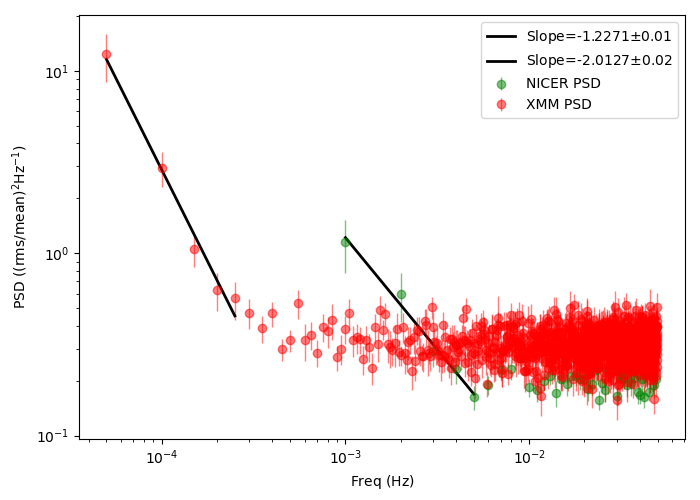

In [35]:
list_LCchunks = get_list_LC(src_lc, plot=False, save=False)
list_PSDchunks = get_list_PSD(list_LCchunks, plot=False, save=False)
PSDavg = average_PSD(list_PSDchunks, save=False)

### Binning the PSD when there is not many chunks
# PSDavg.bin_PSDavg(2)

### Plot PSD graph
plot_PSD(PSDavg, show=False, newfig=False, color=None)
plot_linear_fit(PSDavg, show=True, color=None, exclude=5, return_fit=False)

### Save data
# PSDavg.save_txt(output_pwd + "{}_{}_PSD_binned_bin{:.0f}.txt".format(PSDavg.telescope, PSDavg.object, PSDavg.binsize))
# PSDavg.make_pha(output_pwd + "{}_{}_bin{}_converted_PSD.pha".format(PSDavg.telescope, PSDavg.object, PSDavg.binsize))
# PSDavg.save_pha(output_pwd + "{}_{}_bin{}_converted_PSD.txt".format(PSDavg.telescope, PSDavg.object, PSDavg.binsize))

<br/><br/>

### 3) Calculate Poisson noise

$$ P_{\mathrm{noise}} = \frac{2 (\bar{x} + \bar{x}_b)}{\bar{x}^2} \frac{\Delta T_{\mathrm{samp}}}{\Delta T_{\mathrm{bin}}} \tag{\small eq. A2 in Vaughan 2003} $$


In [ ]:
P_noise = 2 * (np.average(src_lc.count_rate) + np.average(bkg_lc.count_rate)) * src_lc.binsize / (np.average(src_lc.count_rate)**2 * src_lc.binsize)
print("Poisson noise:", P_noise)

Poisson noise: 0.144533969079104
